In [1]:
from myai.imports import *
from visualbench.tasks.function_descent import FunctionDescent
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.inverse import MatrixInverse
from visualbench.tasks.mnist1d_ import MNIST1D
from torchzero.optim.wrappers.scipy import ScipyMinimize
from visualbench.summary import Summary
from myai.datasets.visualbench_plug import MyaiDataset
from myai.datasets import CIFAR10, MNIST
import torchzero as tz

import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, ndim = 2):
        super(BasicBlock, self).__init__()
        self.conv1 = mynn.convnd(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, ndim=ndim)
        self.bn1 = nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = mynn.convnd(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, ndim = ndim)
        self.bn2 = nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                mynn.convnd(in_channels, out_channels, kernel_size=1, stride=stride, bias=False, ndim = ndim),
                nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, in_channels, step = 32, num_classes=10, ndim = 2):
        super(ResNet18, self).__init__()
        self.in_channels = step
        self.conv1 = mynn.convnd(in_channels, step, kernel_size=3, stride=1, padding=1, bias=False, ndim = ndim)
        self.bn1 = nn.BatchNorm2d(step) if ndim == 2 else nn.BatchNorm1d(step)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = mynn.maxpoolnd(kernel_size=3, stride=2, padding=1, ndim = ndim)

        self.layer1 = self._make_layer(BasicBlock, step, 2, stride=1, ndim=ndim)
        self.layer2 = self._make_layer(BasicBlock, step*2, 2, stride=2, ndim=ndim)
        self.layer3 = self._make_layer(BasicBlock, step*4, 2, stride=2, ndim=ndim)
        self.layer4 = self._make_layer(BasicBlock, step*8, 2, stride=2, ndim=ndim)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) if ndim == 2 else nn.AdaptiveAvgPool1d((1,))
        self.fc = nn.Linear(step*8, num_classes)

        self.ndim = ndim

    def _make_layer(self, block, out_channels, num_blocks, stride, ndim):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, ndim))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.ndim == 1 and x.ndim == 2: x = x.unsqueeze(1)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

print(f'{count_params(ResNet18(3, 32, 10)) = }')
print(f'{count_params(ResNet18(1, 8, 10)) = }')


count_params(ResNet18(3, 32, 10)) = 2797610
count_params(ResNet18(1, 8, 10)) = 176258


In [76]:
import torch
from torch.optim import Optimizer
from collections import defaultdict

class HomeoOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.1, beta=1.0, num_iters=5):
        if lr <= 0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if alpha <= 0:
            raise ValueError("Invalid alpha: {}".format(alpha))
        if beta <= 0:
            raise ValueError("Invalid beta: {}".format(beta))
        if num_iters <= 0:
            raise ValueError("Invalid num_iters: {}".format(num_iters))
        
        defaults = dict(lr=lr, alpha=alpha, beta=beta, num_iters=num_iters)
        super(HomeoOptimizer, self).__init__(params, defaults)
        self.state = defaultdict(dict)

    @torch.no_grad
    def step(self, closure=None):
        if closure is None:
            raise ValueError("Closure required for HomeoOptimizer, e.g., loss = model(input)")

        # First pass: compute phi from current theta and save in state
        for group in self.param_groups:
            alpha = group['alpha']
            beta = group['beta']
            for p in group['params']:
                if not p.requires_grad: continue
                state = self.state[p]
                # Compute phi = h(theta) = theta + alpha * tanh(theta / beta)
                theta = p.data
                phi = theta + alpha * torch.tanh(theta / beta)
                state['phi'] = phi.detach()

        # Define wrapped closure to compute loss with theta = h^{-1}(phi)
        def wrapped_closure():
            # Set parameters to theta computed from phi
            for group in self.param_groups:
                alpha = group['alpha']
                beta = group['beta']
                num_iters = group.get('num_iters', 5)
                for p in group['params']:
                    if p.grad is None:
                        continue
                    state = self.state[p]
                    phi = state['phi']
                    # Compute theta from phi via Newton-Raphson
                    theta = phi.clone()
                    for _ in range(num_iters):
                        residual = theta + alpha * torch.tanh(theta / beta) - phi
                        derivative = 1 + (alpha / beta) * (1.0 / torch.cosh(theta / beta)) ** 2
                        theta = theta - residual / derivative
                    p.data.copy_(theta)
            # Compute loss and gradients
            loss = closure()
            return loss

        # Compute loss and gradients with respect to theta
        with torch.enable_grad(): loss = wrapped_closure()

        # Update phi based on gradients
        for group in self.param_groups:
            lr = group['lr']
            alpha = group['alpha']
            beta = group['beta']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                phi = state['phi']
                theta = p.data

                # Compute dtheta/dphi = 1 / (dphi/dtheta)
                sech_sq = (1.0 / torch.cosh(theta / beta)) ** 2
                dphi_dtheta = 1 + (alpha / beta) * sech_sq
                dtheta_dphi = 1.0 / dphi_dtheta

                # Compute gradient w.r.t. phi: dL/dphi = dL/dtheta * dtheta/dphi
                dL_dphi = p.grad.data * dtheta_dphi

                # Update phi: phi_new = phi - lr * dL_dphi
                phi_new = phi - lr * dL_dphi
                state['phi'] = phi_new.detach()

                # Compute new theta from phi_new for the next iteration
                num_iters = group['num_iters']
                theta_new = phi_new.clone()
                for _ in range(num_iters):
                    residual = theta_new + alpha * torch.tanh(theta_new / beta) - phi_new
                    derivative = 1 + (alpha / beta) * (1.0 / torch.cosh(theta_new / beta)) ** 2
                    theta_new = theta_new - residual / derivative
                p.data.copy_(theta_new)

        return loss

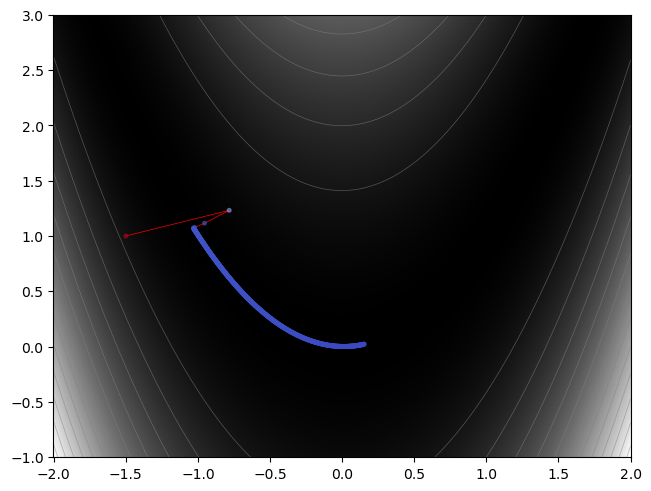

In [81]:
bench = FunctionDescent('rosen')
opt = HomeoOptimizer(bench.parameters(), 1e-3)
bench.run(opt, 1000,)
bench.plot_solution()

In [ ]:
bench.render_video('eveoe')

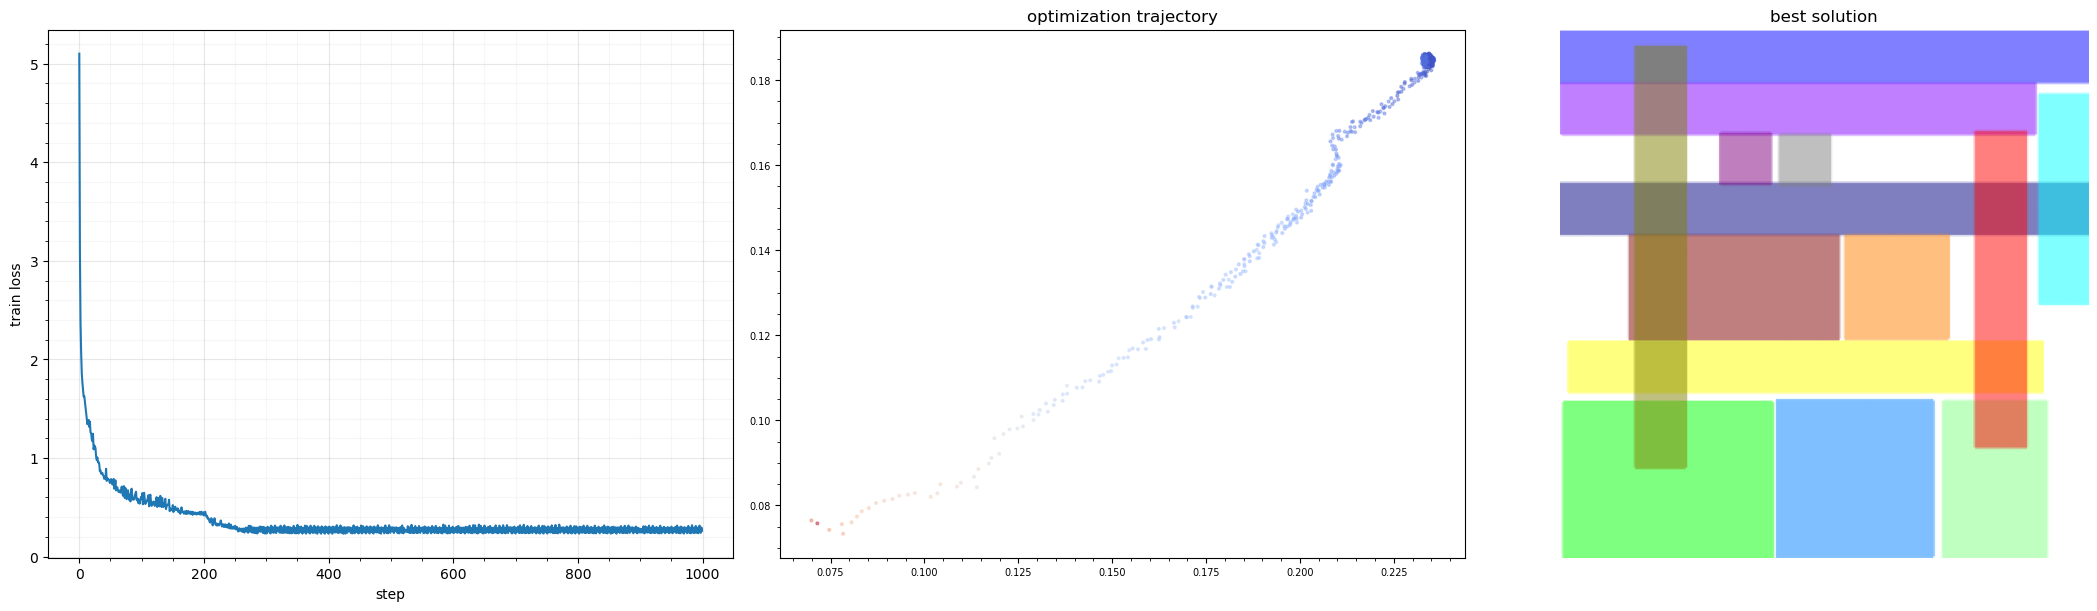

In [78]:
bench = BoxPacking()
opt = HomeoOptimizer(bench.parameters(), 3e-2)
bench.run(opt, 1000)
bench.plot_summary(1, fig=Fig().figsize(24, 6))

In [79]:
bench.render_video('HomeoOptimizer')

1000/1000 | 10.18s               


image.shape = torch.Size([3, 229, 229]), image.numel() = 157323


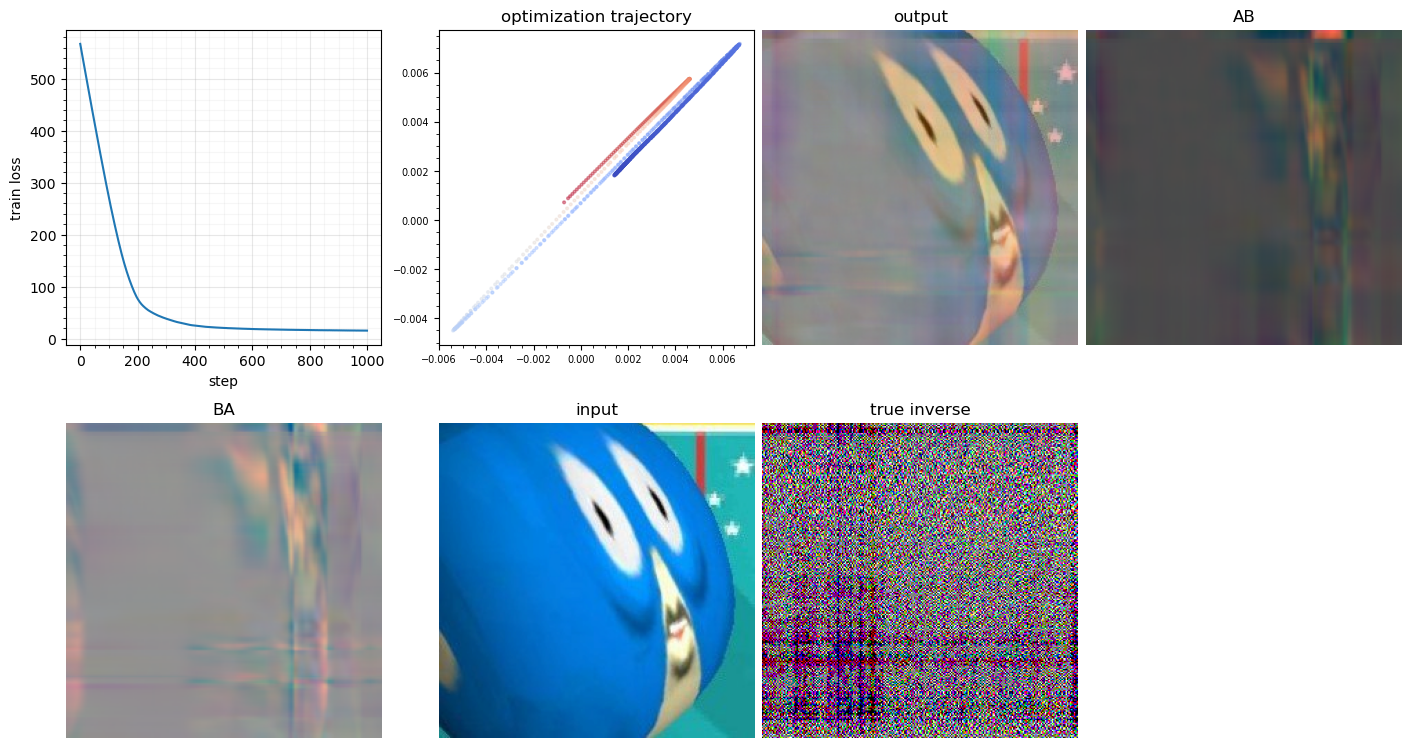

In [11]:
REDUCTION = 0
BW = False

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = TT_SGD(bench.parameters(), 1, 4)
bench.run(opt, 1000)
bench.plot_summary()

In [ ]:
bench.render_video('glesgd inv', scale=4)

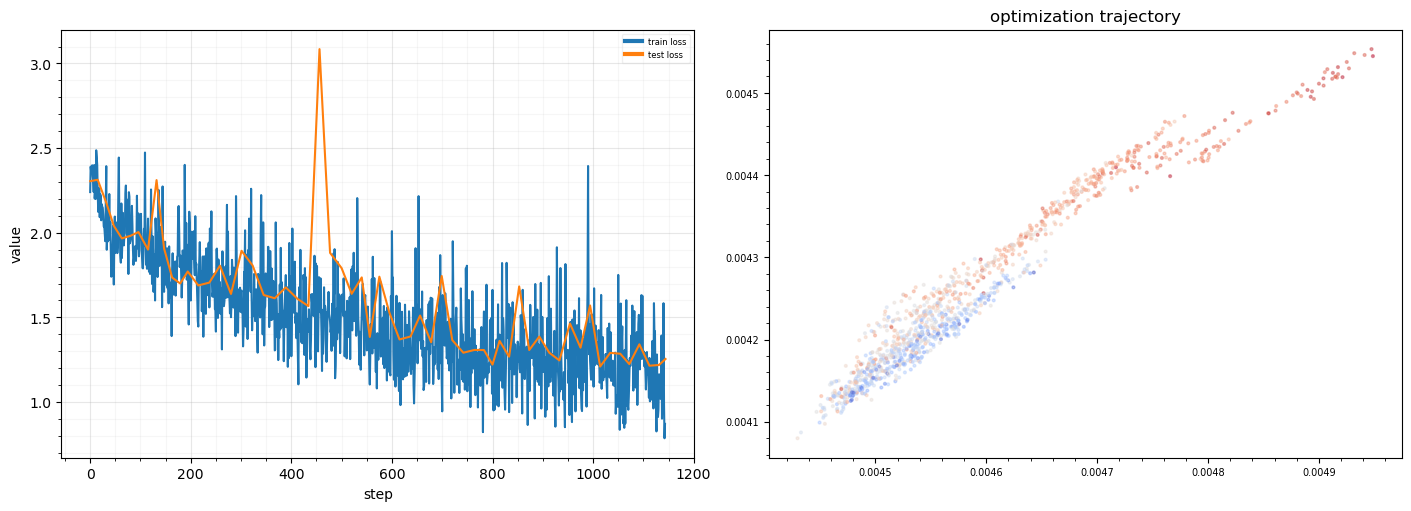

In [14]:
clean_mem()
bench = MNIST1D(
    ResNet18(1, 8, 10, 1),
    loss = F.cross_entropy,
    batch_size = 32,
    test_batch_size = None,
).cuda()

opt = sig(TT_SGD, bench.parameters(), 1e-1, 3)

bench.run(
    opt,
    max_time = 60,
    test_every_sec = 1,
    name = None
)

bench.save_run('MNIST1d-32 runs')
bench.plot_summary()

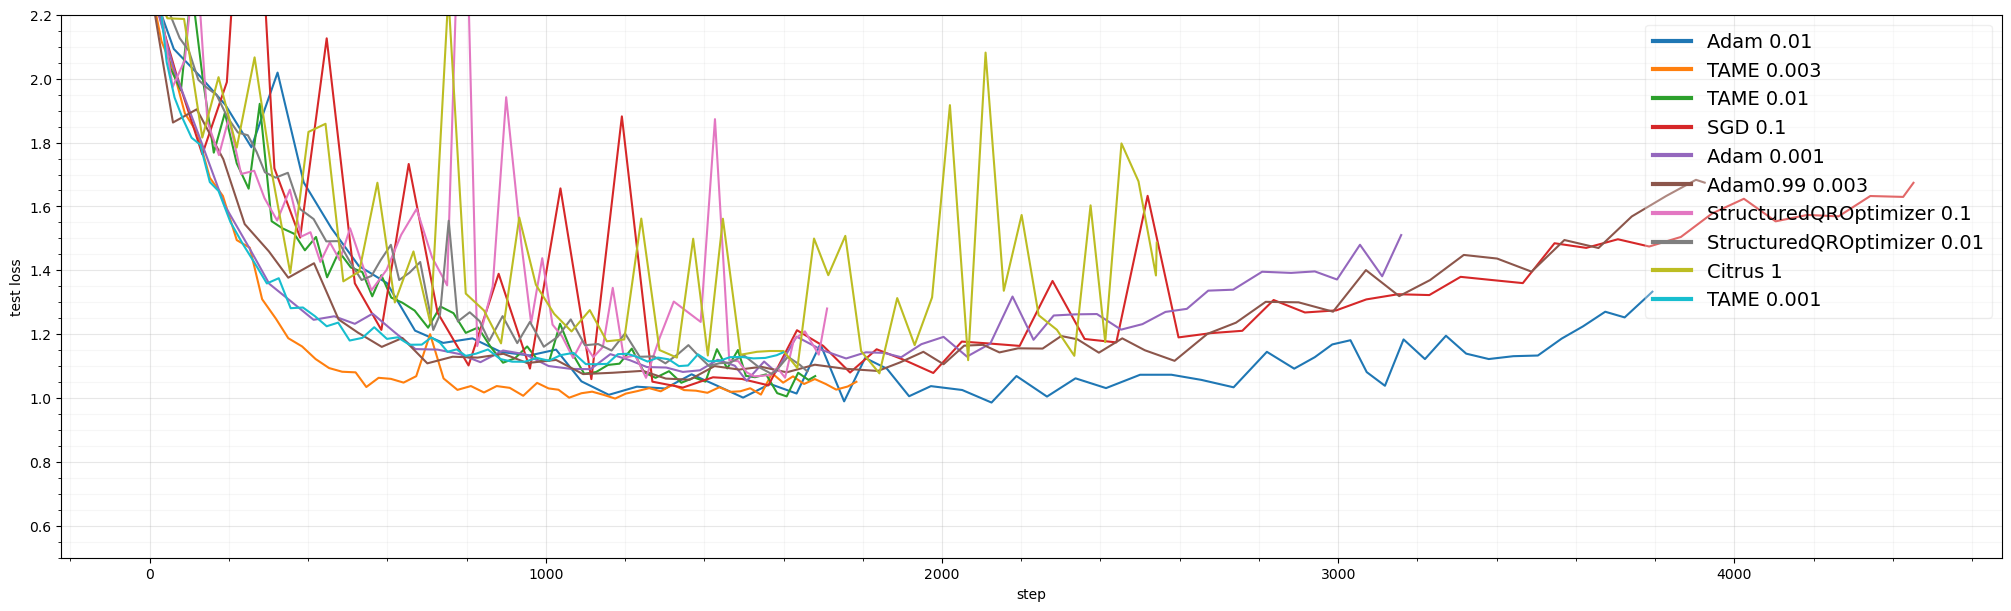

In [85]:
s = Summary.from_runs_dir('MNIST1d-32 runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('test loss', highest=False)
.ylim(0.5, 2.2)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

In [12]:
s = Summary.from_runs_dir('MNIST1d-32 runs')

import polars as pl
pl.Config.set_tbl_rows(100)
s.map_name('name', 'optimizer/lr').sorted_by_metric('test loss', 'min').to_polars('name', 'logger/test loss/min', 'attrs/current_step')

FileNotFoundError: [Errno 2] No such file or directory: 'MNIST1d-32 runs'

In [2]:
from myai.research.optimizers.bad.fft_subspace_crn import FFTSubspaceSCRN

In [3]:
clean_mem()
bench = MNIST1D(
    ResNet18(1, 8, 10, 1),
    loss = F.cross_entropy,
    batch_size = None,
    test_batch_size = None,
)

opt = sig(FFTSubspaceSCRN, bench.parameters(), 10,)

bench.run(
    opt,
    max_time = 60,
    test_every_sec = 1,
    name = None,
)

bench.save_run('MNIST1d-fullbatch runs')
bench.plot_summary()

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.22 GiB. GPU 0 has a total capacity of 3.63 GiB of which 3.26 GiB is free. Process 4504 has 4.90 MiB memory in use. Including non-PyTorch memory, this process has 368.00 MiB memory in use. Of the allocated memory 228.44 MiB is allocated by PyTorch, and 53.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

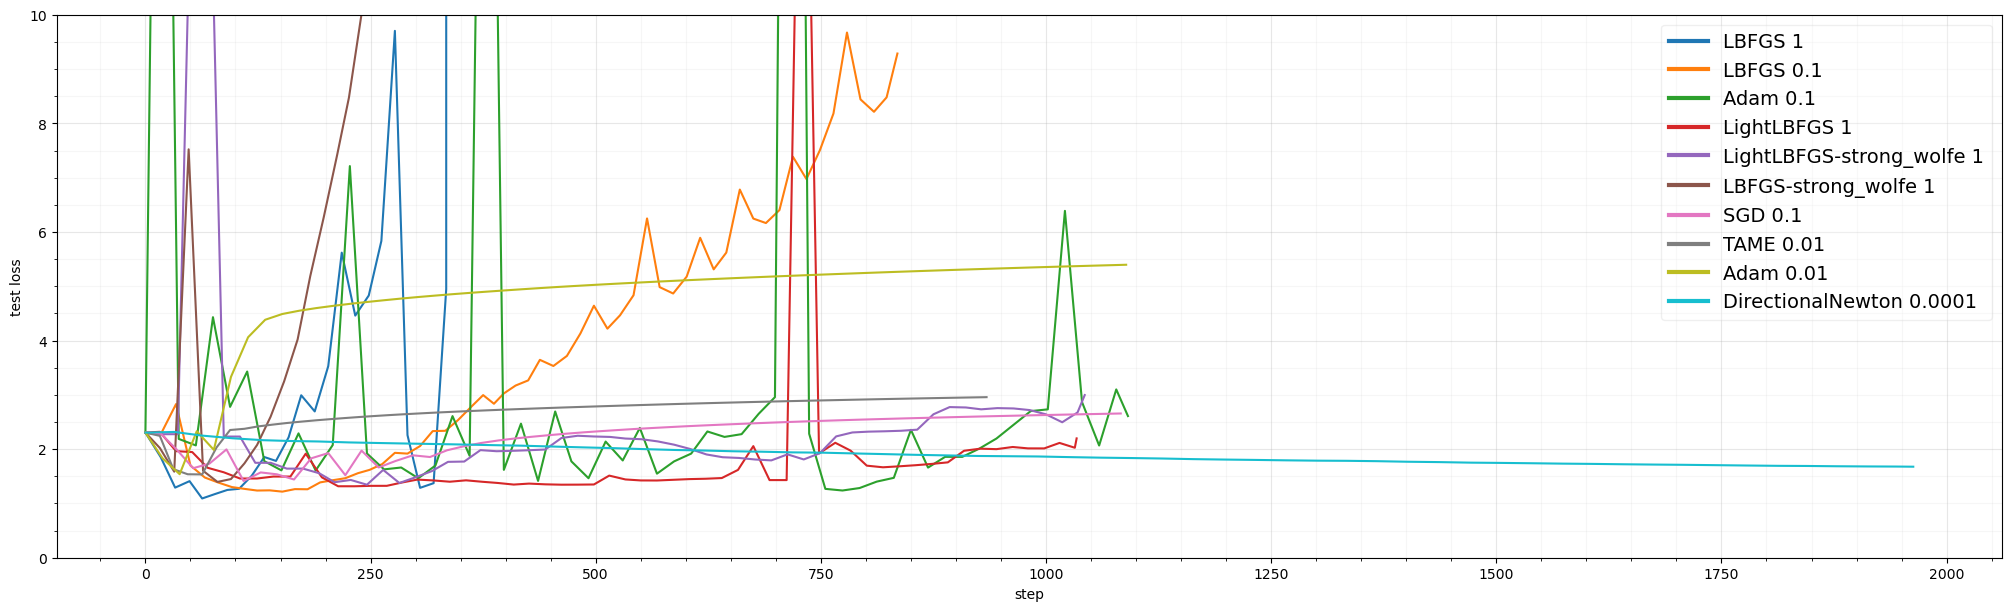

In [8]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('test loss', highest=False)
.ylim(0.0, 10)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

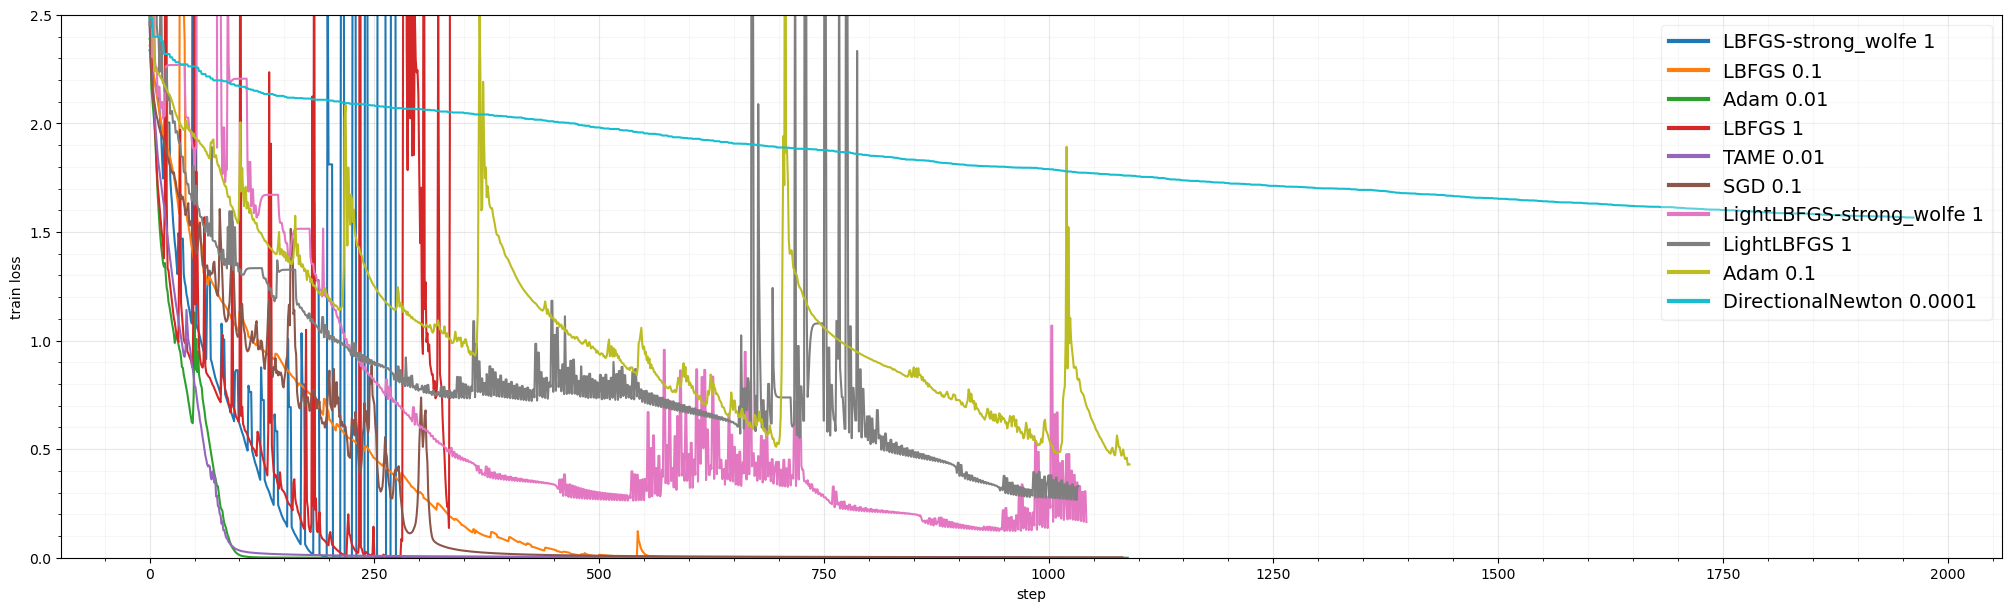

In [9]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('train loss', highest=False,)
.ylim(0.0, 2.5)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

In [8]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')

import polars as pl
pl.Config.set_tbl_rows(100)
s.map_name('name', 'optimizer/lr').sorted_by_metric('test loss', 'min').to_polars('name', 'logger/test loss/min', 'attrs/current_step')

name,logger/test loss/min,attrs/current_step
str,f32,i64
"""LBFGS 1""",1.091433,833
"""StationaryOptimizer 1""",1.199481,1021
"""StationaryOptimizer-strong_wol…",1.209188,1017
"""LBFGS 0.1""",1.21727,835
"""Adam 0.1""",1.238158,1091
"""StationaryOptimizer 0.1""",1.242848,1033
"""LBFGS-strong_wolfe 1""",1.396248,979
"""SGD 0.1""",1.413328,1083
"""Adam 0.01""",1.53852,1089
